In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifierCV


with open('data/train-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    print(data.shape)
    Xtraindata = data.reshape((size, nrows*ncols))
    Xtraindata = Xtraindata.T

with open('data/train-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytrainlabels = data.reshape((size,)) # (Optional)
    ytrainlabels = ytrainlabels.T

    
with open('data/t10k-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    Xtestdata = data.reshape((size, nrows*ncols))
    Xtestdata = Xtestdata.T
    
with open('data/t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))   
    ytestlabels = data.reshape((size,)) # (Optional)

    
traindata_imgs =  np.transpose(Xtraindata).reshape((60000,28,28))    
print(Xtraindata.shape)
print(ytrainlabels.shape)
print(Xtestdata.shape)
print(ytestlabels.shape)


(47040000,)
(784, 60000)
(60000,)
(784, 10000)
(10000,)


In [2]:
def plot_digits(XX, N, title):
    fig, ax = plt.subplots(N, N, figsize=(6, 6))
    
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[:,(N)*i+j].reshape((28, 28)), cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)


The dimension of the first 16 PCA modes is (784, 16)


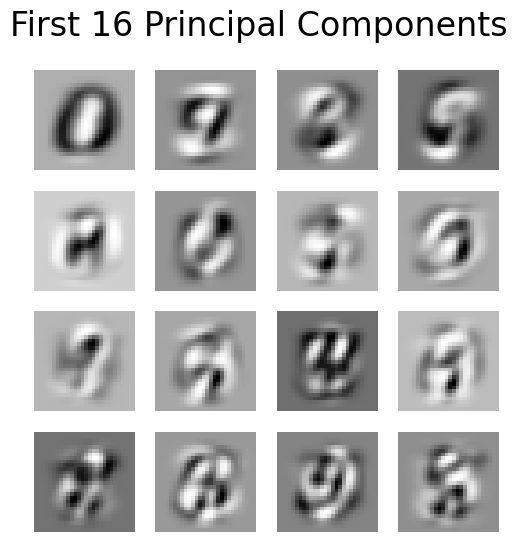

In [15]:
# Perform PCA analysis
n_components = 16  # Number of principal components
pca = PCA(n_components = n_components)
Xtraindata_pca = pca.fit(Xtraindata.T) # transpose the raw data to let rows to be num of samples, to fit the convention of the function

pc_modes = np.transpose(pca.components_) # transpose back


plot_digits(pc_modes, 4, "First 16 Principal Components")
print("The dimension of the first 16 PCA modes is", pc_modes.shape)

Text(0.5, 1.0, 'Cumulative Energy of singular values')

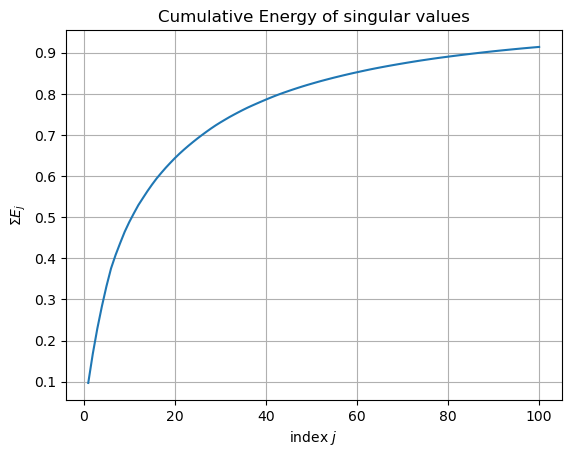

In [4]:
n_components = 100  # Number of principal components
pca = PCA(n_components=n_components)
Xtraindata_pca = pca.fit(Xtraindata.T)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(1, n_components + 1), cumulative_variance)


plt.xlabel('index $j$')
plt.ylabel('$\Sigma E_j$')
plt.grid(True)
plt.title("Cumulative Energy of singular values")

In [5]:
num_modes_needed = np.argmax(cumulative_variance >= 0.85) + 1
print(f"Number of PCA modes needed for {0.85 * 100}% energy: {num_modes_needed}")

Number of PCA modes needed for 85.0% energy: 59


In [6]:
#Task 3

def select_subset(X_train, y_train, X_test, y_test, digit_chose):
    '''
    Select a subset of the chosen digits from the MNIST dataset, and return the four subsets.
    
    Parameters:
    - digit_list: the chosen digits in an array (e.g., choosing digits 1 and 2: np.array([1, 2]).
    '''
    boolean_train = np.isin(y_train, digit_chose)
    X_subset_train = X_train[boolean_train]
    y_subset_train = y_train[boolean_train]
    
    boolean_test = np.isin(y_test, digit_chose)
    X_subset_test = X_test[boolean_test]
    y_subset_test = y_test[boolean_test]
    
    return X_subset_train, y_subset_train, X_subset_test, y_subset_test

In [7]:
choose_digits = np.array([1, 8])
X_subtrain_18, y_subtrain_18, X_subtest_18, y_subtest_18 = select_subset(Xtraindata.T, ytrainlabels, 
                                                                   Xtestdata.T, ytestlabels, choose_digits)

In [8]:
from sklearn.model_selection import cross_val_score

k = 59
pca = PCA(n_components = k)
pca.fit(Xtraindata.T)
pc_modes = pca.components_
X_subtrain_18_proj = pc_modes @ X_subtrain_18.T  # Project data on 59-PCA space

#Ridge Classifier
RidgeCL = RidgeClassifierCV()
RidgeCL.fit(X_subtrain_18_proj.T, y_subtrain_18)
print("Training Score for digits 1 and 8: {}".format(RidgeCL.score(X_subtrain_18_proj.T, y_subtrain_18)))

#Cross-Validation
scores = cross_val_score(RidgeCL, X_subtrain_18_proj.T, y_subtrain_18, cv=5)
scores
print("{} accuracy with a standard deviation of {} for training data".format(scores.mean(), scores.std()))

# Testing
X_subtest_18_proj = pc_modes @ X_subtest_18.T
print("Testing Score for digits 1 and 8: {}".format(RidgeCL.score(X_subtest_18_proj.T, y_subtest_18)))


Training Score for digits 1 and 8: 0.9664893194631938
0.9642661444191736 accuracy with a standard deviation of 0.0026656346829298677 for training data
Testing Score for digits 1 and 8: 0.9800853485064012


/Users/emmazhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/emmazhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


In [9]:
choose_digits = np.array([3, 8])
X_subtrain_38, y_subtrain_38, X_subtest_38, y_subtest_38 = select_subset(Xtraindata.T, ytrainlabels, 
                                                                   Xtestdata.T, ytestlabels, choose_digits)
X_subtrain_38_proj = pc_modes @ X_subtrain_38.T

RidgeCL = RidgeClassifierCV()
RidgeCL.fit(X_subtrain_38_proj.T, y_subtrain_38)
print("Training Score for digits 3 and 8: {}".format(RidgeCL.score(X_subtrain_38_proj.T, y_subtrain_38)))

# Cross-validation
scores = cross_val_score(RidgeCL, X_subtrain_38_proj.T, y_subtrain_38, cv=5)
scores
print("{} accuracy with a standard deviation of {} for training data".format(scores.mean(), scores.std()))

# Testing
X_subtest_38_proj = pc_modes @ X_subtest_38.T
print("Testing Score for digits 3 and 8: {}".format(RidgeCL.score(X_subtest_38_proj.T, y_subtest_38)))


Training Score for digits 3 and 8: 0.9603572024703723
0.9586887267960856 accuracy with a standard deviation of 0.006168373893718586 for training data
Testing Score for digits 3 and 8: 0.9642137096774194


/Users/emmazhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/emmazhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


In [10]:
choose_digits = np.array([2, 7])
X_subtrain_27, y_subtrain_27, X_subtest_27, y_subtest_27 = select_subset(Xtraindata.T, ytrainlabels, 
                                                                   Xtestdata.T, ytestlabels, choose_digits)


X_subtrain_27_proj = pc_modes @ X_subtrain_27.T

RidgeCL = RidgeClassifierCV()
RidgeCL.fit(X_subtrain_27_proj.T, y_subtrain_27)
print("Training Score for digits 2 and 7 using Ridge: {}".format(RidgeCL.score(X_subtrain_27_proj.T, y_subtrain_27)))

# Cross-Validation
scores = cross_val_score(RidgeCL, X_subtrain_27_proj.T, y_subtrain_27, cv=5)
scores
print("{} accuracy with a standard deviation of {} for training data".format(scores.mean(), scores.std()))

# Testing
X_subtest_27_proj = pc_modes @ X_subtest_27.T
print("Testing Score for digits 2 and 7 using Ridge: {}".format(RidgeCL.score(X_subtest_27_proj.T, y_subtest_27)))


Training Score for digits 2 and 7 using Ridge: 0.9802830728953612
0.9795468557027099 accuracy with a standard deviation of 0.0018099215906928119 for training data
Testing Score for digits 2 and 7 using Ridge: 0.974757281553398


/Users/emmazhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/emmazhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


In [11]:
# Task-6: Classify all digits

# Training-Ridge
Xtrain_proj = pc_modes @ Xtraindata
RidgeCL = RidgeClassifierCV()
RidgeCL.fit(Xtrain_proj.T, ytrainlabels)
print("Training Score for all digits using Ridge: {}".format(RidgeCL.score(Xtrain_proj.T, ytrainlabels)))

# Cross-val
scores = cross_val_score(RidgeCL, Xtrain_proj.T, ytrainlabels, cv=5)
scores
print("{} accuracy with a standard deviation of {} for training data".format(scores.mean(), scores.std()))

# Testing-Ridge
Xtest_proj = pc_modes @ Xtestdata
print("Testing Score for all digits using Ridge: {}".format(RidgeCL.score(Xtest_proj.T, ytestlabels)))

Training Score for all digits using Ridge: 0.8452


/Users/emmazhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/emmazhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


0.8439 accuracy with a standard deviation of 0.009570121327455687 for training data
Testing Score for all digits using Ridge: 0.8564


/Users/emmazhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


In [12]:
# KNN Classifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(Xtrain_proj.T)
X_test = scaler.transform(Xtest_proj.T)

KNNCL = KNeighborsClassifier(n_neighbors=3)
KNNCL.fit(X_train, ytrainlabels)
print("Training Score using KNN: {}".format(KNNCL.score(X_train, ytrainlabels)))

# Cross-val
scores = cross_val_score(KNNCL, X_train, ytrainlabels, cv=5)
scores
print("{} accuracy with a standard deviation of {} for training data".format(scores.mean(), scores.std()))

# Testing
print("Testing Score using KNN: {}".format(KNNCL.score(X_test, ytestlabels)))

/Users/emmazhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Training Score using KNN: 0.9829166666666667


/Users/emmazhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/emmazhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

0.9609833333333333 accuracy with a standard deviation of 0.0014789260367652666 for training data
Testing Score using KNN: 0.961


/Users/emmazhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [13]:
# LDA Classifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDACL = LinearDiscriminantAnalysis()
LDACL.fit(Xtrain_proj.T, ytrainlabels)
print("Training Score using LDA: {}".format(LDACL.score(Xtrain_proj.T, ytrainlabels)))

# Cross-Val
scores = cross_val_score(LDACL, Xtrain_proj.T, ytrainlabels, cv=5)
scores
print("{} accuracy with a standard deviation of {}".format(scores.mean(), scores.std()))

# Testing
print("Testing Score using LDA: {}".format(LDACL.score(Xtest_proj.T, ytestlabels)))

Training Score using LDA: 0.8666166666666667
0.8651166666666666 accuracy with a standard deviation of 0.008634491556799665
Testing Score using LDA: 0.8752
